POISSON BLENDING

In [188]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.sparse import linalg as linalg
%matplotlib inline

In [189]:
#loading images
target=cv2.imread('target.jpg')
source=cv2.imread('source.png')

#variables
w=source.shape[0]
h=source.shape[1]
# h1=50
# w1=460
h1=155
w1=365
n=w*h

Here I define a "mask" in order to have the location of source on target in matrix form:

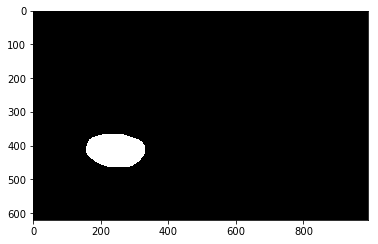

In [190]:
mask=np.zeros(target.shape)

mask2=np.zeros(source.shape)
mask2=np.where(source==0,0,255)

mask[w1:w1+source.shape[0],h1:h1+source.shape[1],:]=mask2
mask = cv2.blur(mask,(5,5))
kernel = np.ones((7,7),np.uint8)
mask = cv2.erode(mask,kernel,iterations = 1)
plt.imshow(mask)

In order to apply poisson blendin for adding a part of source to our target we need to know points inside,on edge,and outside the region of new picture.Methods below define the posission of point (i,j):

In [191]:
def is_outside(i,j):
    if (i==0) | (j==0) | (j==h-1) | (i==w-1):
        return True
    if (mask[w1+i][h1+j][0]==0):
        return True
    return False

In [192]:
def on_edge(i,j):
    if is_outside(i,j):
        return False
    for k in range(1,9):
        if i+k<w:
            if is_outside(i+k,j)==True:
                return True
        if j+k<h:
            if is_outside(i,j+k)==True:
                return True
        if i-k>=0:
            if is_outside(i-k,j)==True:
                return True
        if j-k>=0:
            if is_outside(i,j-k)==True:
                return True 
    return False    

In [193]:
def is_inside(i,j):
    if is_outside(i,j)==True:
        return False
    if on_edge(i,j)==True:
        return False
    return True

To find new values of a point (in source) we need its laplacian which we know is calculated with its neighbors.But here to exclude noise and emphasize on inside points (and also according to formula in slides) we dont consider points that are not inside:

In [194]:
def laplac_source(x,y,num):
    res=0
    if is_inside(x-1,y):
        res=res+source[x][y][num]-source[x-1][y][num]
    if is_inside(x,y-1):
        res=res+source[x][y][num]-source[x][y-1][num]
    if is_inside(x,y+1):
        res=res+source[x][y][num]-source[x][y+1][num]
    if is_inside(x+1,y):
        res=res+source[x][y][num]-source[x+1][y][num]
        
    return res

Now for handling the linear system that should be solved to get new values of points,we need a map of indexing to map (i,j)'s to indexes between 0 to n (indexes of result vector):

In [195]:
def inverse_index(k):
    i=k/h
    j=k-(i*h)
    return [i,j]

In [196]:
def get_index(i,j):
    return (i*h)+j

To build A matrix we should consider the fact that most of its values are 1  and zero and its similar to identity matrix.There are some 4's and (-1)'s for points that are inside the region and its neighbors(respectively) which can be identified by methods that were mentioned before.

In [197]:
A=np.identity(n)

In [198]:
for i in range(0,w-1):
    for j in range(0,h-1):
        if is_inside(i,j)==True:
            k=get_index(i,j)
            A[k][k]=4
            
            if is_inside(i,j+1):
                A[k][get_index(i,j+1)]=(-1)
            if is_inside(i,j-1):
                A[k][get_index(i,j-1)]=(-1)
            if is_inside(i+1,j):
                A[k][get_index(i+1,j)]=(-1)
            if is_inside(i-1,j):
                A[k][get_index(i-1,j)]=(-1)

Obviously to solve linear system Ax=b we need A2=inverse(A) so that we can get values of x vector by calculating x=A2.b.
I got A-inverse with a numpy method which unfortunatley takes about 2 minutes to give us the result:

In [199]:
#inverse A
A2=np.linalg.inv(A)

To create vector "b", I defined a method to have a certain b for each color rgb and get answers of "x" for each color.

Values of "b" depends on whether the point is inside,outside or on the edge of the region.

If it was inside,value would be laplacian of that point in source image,so that laplacian of the point could be the same in the new image and also if it has on_edge neighbors we add their values in target image in order to have color of target image in our new source.

And if the point was outside the region the value will be the same as the one in target.

In [200]:
def create_B(color):
    B = np.zeros((n,1))
    for k in range(0,n-1):
        i,j=inverse_index(k)

        if is_inside(i,j):
            B[k][0]=laplac_source(i,j,color)
            if on_edge(i,j+1)==True:
                B[k][0]=B[k][0]+target[w1+i][h1+j+1][color]
            if on_edge(i+1,j)==True:
                B[k][0]=B[k][0]+target[w1+i+1][h1+j][color]
            if on_edge(i,j-1)==True:
                B[k][0]=B[k][0]+target[w1+i][h1+j-1][color]
            if on_edge(i-1,j)==True:
                B[k][0]=B[k][0]+target[w1+i-1][h1+j][color]
                
        else:
            B[k][0]=target[w1+i][h1+j][color]
    return B  

Here we get "b" for each color and calculate x for each color using A2 which we defined before:

In [201]:
b0=create_B(0)
b1=create_B(1)
b2=create_B(2)

In [202]:
X0=A2.dot(b0)
X1=A2.dot(b1)
X2=A2.dot(b2)

In [203]:
X0=np.where(X0<0,0,X0)
X1=np.where(X1<0,0,X1)
X2=np.where(X2<0,0,X2)
X0=np.where(X0>255,255,X0)
X1=np.where(X0>255,255,X1)
X2=np.where(X0>255,255,X2)

Mapping result of linear system into an image matrix:

In [204]:
result=np.where(mask==0,target,0)
for k in range(0,n):
    x,y=inverse_index(k)
    if(mask[w1+x][h1+y][0]!=0):
        result[w1+x][h1+y][0]=X0[k]
        result[w1+x][h1+y][1]=X1[k]
        result[w1+x][h1+y][2]=X2[k]

In [205]:
cv2.imwrite('res1.jpg',result)

True